In [1]:
import numpy as np
import pImpactR as impact
from copy import deepcopy as copy
import matplotlib.pyplot as plt
from math import ceil
import os

In [2]:
np.set_printoptions(formatter={'float': lambda x: format(x, '1.2E')})
NTURN = [128,256,512,1024,2048]
nTurn = NTURN[0]
betx = 1.9065054393933862
alfx = 1.408226172730429
emitx = 6.066503e-6
nCore_y = 8
nCore_z = 4
n_particles = 1024000
nx = 100
NL_t  = 0.4
NL_c  = 0.01
# NL_nu = 0.3034496449165134
# NL_L  = 1.8
print('singular point = ', NL_c*np.sqrt(betx))
pipe_radius = 0.02*np.sqrt(2.0)
#pipe_radius = 0.013
#pipe_radius = 0.01

singular point =  0.013807626296338507


In [3]:
beam, lattice = impact.readInputFile('../test_IOTA.in')

reading ImpactZ input file (../test_IOTA.in)
  : mpi task info .............................done
  : simulation control parameters .............done
  : space charge field solver, mesh info ......done
  : dist-type,restart,subcycle,#of state ......done
  : Multiple Charge State info ................done
  : particle distribution info ................done
  : beam reference orbit info .................done
  : converting impact dist to twiss param......done
  : lattice info ..............................done


In [4]:
beam.nCore_y = nCore_y
beam.nCore_z = nCore_z
beam.distribution.emitx = emitx
beam.n_particles = n_particles

ke   = beam.kinetic_energy
mass = beam.mass
freq = beam.frequency

### Read fort.256

In [5]:
pDataInit = impact.readParticleData(256,ke,mass,freq,format_id=2)
pDataInit.shape

(1027477, 9)

In [6]:
nptTest = 3834
indexCore = pDataInit[:,-1] > nptTest
pDataTmp=pDataInit[indexCore,:]
pDataTmp.shape

(1024000, 9)

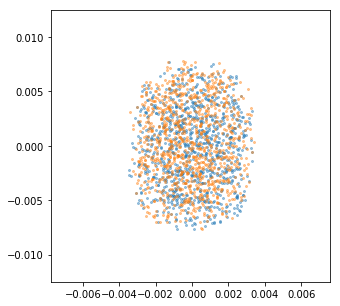

In [7]:
plt.figure(figsize=(5,5))
plt.scatter(pDataTmp[:1024 ,0],pDataTmp[:1024 ,2],s=4,alpha=0.4)
plt.scatter(pDataTmp[-1024:,0],pDataTmp[-1024:,2],s=4,alpha=0.4)

In [8]:
##### 1.2.1. generate pData

In [9]:
##### 1.2.2. reOrder pData s.t. y>0 comes first

In [10]:
pData = copy(pDataTmp)
iTmp = np.argwhere(pData[:,2]>=0)[:,0]
jTmp = np.argwhere(pData[:,2] <0)[:,0]
pData[:len(iTmp),:] = pDataTmp[iTmp,:]
pData[len(iTmp):,:] = pDataTmp[jTmp,:]
pData[:,-1] = np.arange(1,len(pData)+1)
npt_yup = len(iTmp)
print('npt_yup=',npt_yup)

npt_yup= 512246


In [11]:
# impact.plot.density(pData[:len(iTmp),0],pData[:len(iTmp),2])

In [12]:
# impact.plot.density(pData[len(iTmp):,0],pData[len(iTmp):,2])

In [13]:
# impact.plot.density(pData[:,0],pData[:,2])

In [14]:
##### 1.2.3. generate testP

In [15]:
testP = 0.0
k=0
q_m = beam.multi_charge.q_m[0]
pTest = []
nx = 100
xmax = 0.98
for x in np.linspace(-xmax,xmax,nx):
    for y in np.linspace(-xmax,xmax,nx):
        if x**2+y**2<=xmax**2 and y>0:
            k+=1
            pTest.append([x,0.0,y,0.0,0.0,0.0,q_m,0.0,k]) 
pTest = np.array(pTest)
nptTest = len(pTest)
print('nptTest=',nptTest)

nptTest= 3834


In [16]:
def normalize(data):
    data[:,1] = (data[:,0]*alfx/np.sqrt(betx) + data[:,1]*np.sqrt(betx))/NL_c
    data[:,3] = (data[:,2]*alfx/np.sqrt(betx) + data[:,3]*np.sqrt(betx))/NL_c
    data[:,0] = data[:,0]/(np.sqrt(betx)*NL_c)
    data[:,2] = data[:,2]/(np.sqrt(betx)*NL_c)
    
def unnormalize(data):
    data[:,1] = (-data[:,0]*alfx + data[:,1])*NL_c/np.sqrt(betx)
    data[:,3] = (-data[:,2]*alfx + data[:,3])*NL_c/np.sqrt(betx)
    data[:,0] = data[:,0]*np.sqrt(betx)*NL_c
    data[:,2] = data[:,2]*np.sqrt(betx)*NL_c

In [17]:
unnormalize(pTest)

In [18]:
##### 1.2.4. combine pData, pTest  and Check

In [19]:
pData[:,8] = pData[:,8] + nptTest
if nptTest>0:
    pData = np.concatenate((pTest,pData),axis=0)
print(pData.shape)
impact.writeParticleData(pData, ke, mass, freq)

(1027834, 9)


In [20]:
loop = impact.getElem('loop')
loop.turns = 1

write_pData = impact.getElem('write_raw_ptcl')
write_pData.turn = 1
write_pData.file_id = 111110
write_pData.format_id = 2

beam.n_particles = n_particles + nptTest
beam.distribution.distribution_type = 'ReadFile'
impact.writeInputFile(beam,[loop,write_pData]);
impact.run(beam)

IMPACTz: linear dipoel finge model and linear drift propagator is assumed...


0

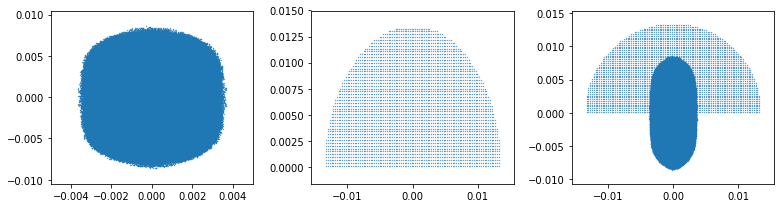

In [21]:
pDataInit = impact.readParticleData(111110,ke,mass,freq,format_id=2)
plt.figure(figsize=[11,3])
plt.subplot(1,3,1)
plt.scatter(pDataInit[nptTest:,0],pDataInit[nptTest:,2],s=0.1);
plt.subplot(1,3,2)
plt.scatter(pDataInit[:nptTest,0],pDataInit[:nptTest,2],s=0.1);
plt.subplot(1,3,3)
plt.scatter(pDataInit[:,0],pDataInit[:,2],s=0.1);
plt.tight_layout()

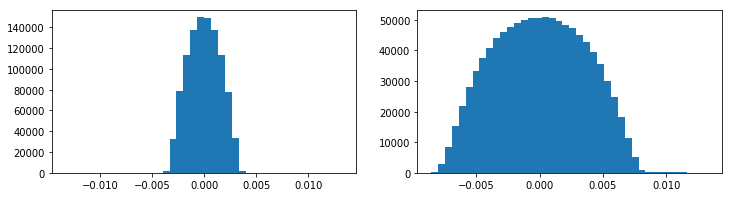

In [22]:
plt.figure(figsize=(12,3))
plt.subplot(1,2,1)
plt.hist(pDataInit[:,0],bins=40);
plt.subplot(1,2,2)
plt.hist(pDataInit[:,2],bins=40);